# Monk3
Grid Search for Monk1 dataset model selection


In [175]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk3
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk3 dataset 

In [176]:
training_data, training_labels, test_data, test_labels = read_monk3("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [177]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [178]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [179]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 32
epochs = 500

if not os.path.exists('monk3_models_configs.json'):
    dir_path = "Monk3/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=10, workers=8,                             number_of_initializations=5,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json('monk3_models_configs.json')
else: 
    with open('monk3_models_configs.json', 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [180]:
models = []
ea = EarlyStoppingCallback(patiente_limit=50)
with tqdm(total=len(configs)) as pbar:
    for config in configs:
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


In [181]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
# df_sorted = df_sorted[df_sorted['Accuracy'] >= 0.95]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 0.96]
df_sorted = df_sorted[df_sorted['History_Std'] <= 0.1]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,History,Model,Config,Num_Layers,Num_of_Units,Name
15,0.028961,0.060530,0.975410,0.029166,0.960648,400,"[0.5129057068399975, 0.5095324621508476, 0.507...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.76,...",1,[3],Model287973
42,0.084114,0.066866,0.934426,0.071294,0.972222,87,"[0.5000616877746826, 0.49998112363586805, 0.49...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.78,...",1,[3],Model364957
17,0.084137,0.045552,0.934426,0.068423,0.972222,126,"[0.5056799701590933, 0.4986757275929659, 0.497...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.82,...",1,[2],Model332939
35,0.084284,0.067752,0.934426,0.069962,0.972222,46,"[0.5138725340869795, 0.49896576906301493, 0.49...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.77,...",1,[4],Model371342
75,0.084346,0.066315,0.934426,0.066900,0.972222,67,"[0.5001085070622623, 0.4997246841395327, 0.499...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.77,...",1,[4],Model371359
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.122167,0.048201,0.934426,0.117182,0.972222,57,"[0.4985166158511673, 0.49715890830177606, 0.49...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.76,...",1,[4],Model378063
64,0.122236,0.046726,0.934426,0.112237,0.972222,62,"[0.4889675647815615, 0.4907191345004356, 0.493...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.76,...",1,[4],Model378062
65,0.124010,0.045670,0.934426,0.118569,0.972222,50,"[0.4754175043118882, 0.4922898032375954, 0.494...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.76,...",1,[3],Model378061
67,0.132944,0.051794,0.934426,0.126806,0.972222,52,"[0.4999113002211337, 0.49983635699845713, 0.50...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.1, 'learning_rate': 0.76,...",1,[1],Model377905


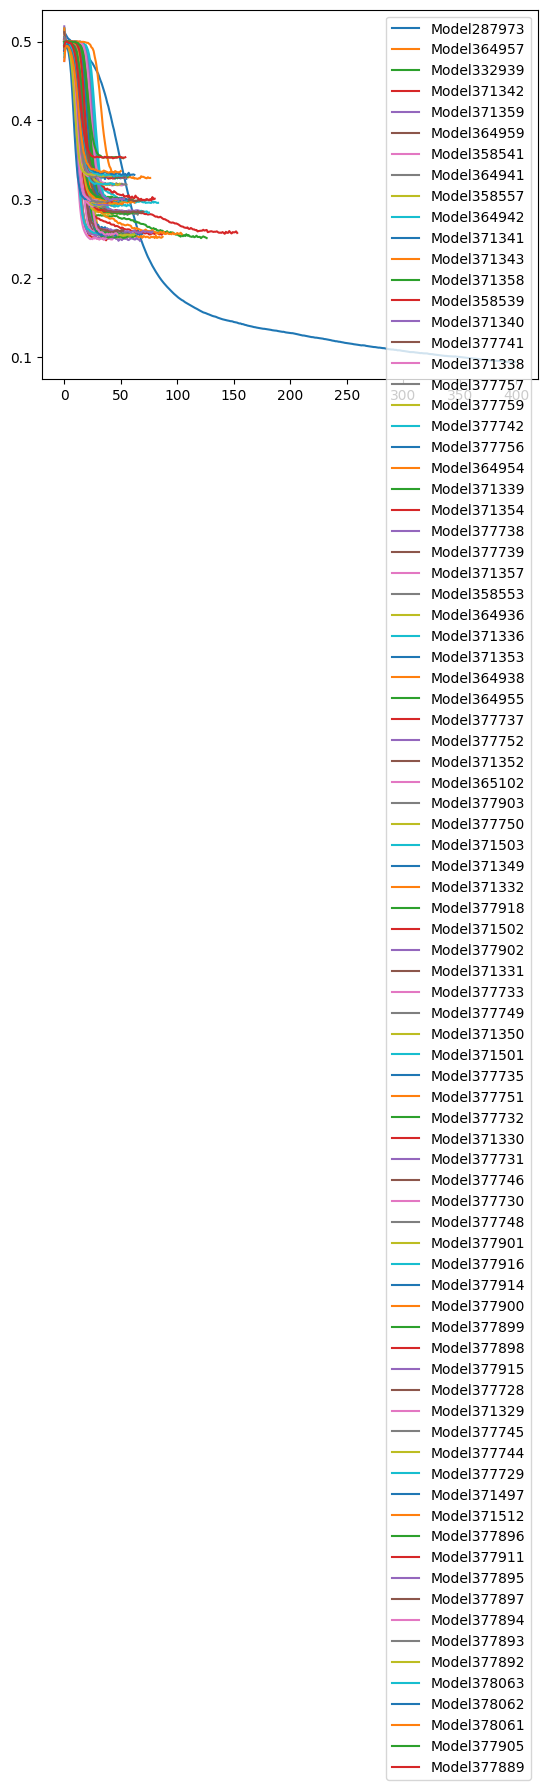

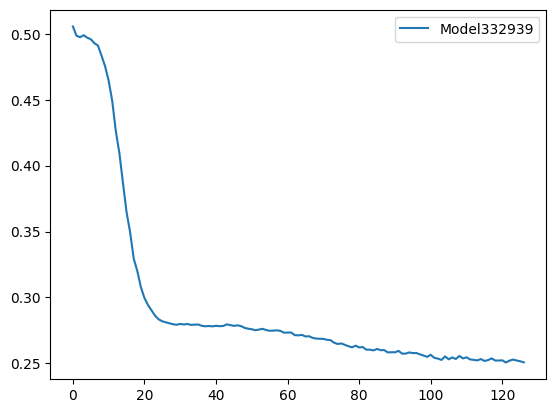

In [184]:
plot_history(histories)
plot_history({'Model332939': histories['Model332939']})
